<br/>
<br/>
<br/>

# <center>An Analysis of the Culinary Scene in Oslo, Norway -<center> using K-Means, Foursquare and GeoPy

### <center>An Assignment for the 'Data Analytics using Python'-course at UC San Diego Extension<center> <br/>by Arne Martin Fevolden

### <center>Course instructor: Michael Galarnyk<center>
    
<br/>
<br/>
<br/>

## Background

This is an assignment for the 'Data Analytics using Python'-course at UC San Diego Extension. The original inspiration for the analysis comes from the Capstone project for the IBM Data Science Professional Certification (offered through Coursera), which I completed in April 2019. The IBM Capstone assignment involved using FourSquare venue data and K-means cluster analysis to carry out an analysis of our own choosing. My project analysed the restaurant sector in Oslo. (It can be found at https://github.com/enraarne/Coursera_Capstone ).

This assignment draws on the Capstone project in the sense that it also analyses the restaurant sector in Oslo and employs both Foursquare data and K-means cluster methodology. Apart from that, the analysis has been completely reworked. The assignment is submitted in fulfilment of the requirements for the 'Data Analytics using Python'-course ‘Option B: Improve a Python project from another class.’ Based on the skills I have acquired through this course, I have, among others, improved the previous project in the following way: 

- Assemble a much bigger data set, with over 70 restaurant locations which is used in the cluster analysis (in contrast to 15 before).
- Use GeoPy Nominatim for geocoding
- Employ more effective coding strategies (such as masks for altering DataFrames)
- Use web scraping more extensively and the FourSquare API more effectively
- Use the ‘elbow analysis’ to test the number of clusters to use in the cluster analysis.  

## The structure of the data analysis:

This analysis is based on the following case: The owners of the fictitious Chinese restaurant ‘Food Scientist’ (食品科學家) want to find a good location for opening another restaurant in Oslo. A good location is defined as a location that has strong demand for the restaurant’s services and moderate competition from other restaurants. (For more on the case see the accompanying PowerPoint presentation.) To find this location, the data analysis has been structured in the following way:

**A: Defining the restaurant districts in Oslo.** The first part of the analysis creates an overview of the different restaurant districts in Oslo. Since there is no established definition of restaurant districts, we need to find some method of distinguishing between different restaurant locations. In this analysis will use the stations on the city's subway and tramway network as a proxy for the restaurant districts, since restaurants in Oslo tend to cluster around these connection points. We will create an overview of these stations by "scraping" the transit network from Wikipedia pages.

**B: Finding the coordinates for the restaurant districts.** This part of the analysis will find the decimal degrees (DD) coordinates for the restaurant districts (which will later be used to access and collect venue data from the FourSquare API). The coordinates are gathered by geocoding the subway and tramway stations using GeoPy Nominatim.

**C: Populating Restaurant districts with restaurant venues.** In the third part of the analysis, we will access and download restaurant venues using the FourSquare API. We will separate between 'downtown districts', where we populate the district with all restaurants within a kilometer's radius, and 'residential districts', where we search for all restaurants within a two kilometers' radius. This is done to reduce overlap of restaurant venues, while ensuring that few restaurants are left out of the analysis.   

**D: Map the competitive situation in each restaurant district.** A good indicator for competition is the presence of Chinese and other Asian restaurants. In this part of the analysis, we will use the FourSquare venue data to find out how many Chinese and other Asian restaurants are present in each restaurant district. The results will be presented in both tables and Folium maps.  

**E: Cluster the restaurant districts to measure similarities.** The last part of the analysis will use K-means cluster analysis to find restaurant districts that are similar to the original location of the Chinese restaurant ‘Food Scientist’. These locations should provide a "good fit" for a new restaurant and there should be a strong demand for the Chinese restaurant’s services. The cluster analysis is carried out using SciKit-Learn. 



## A: Defining the Restaurant districts in Oslo:

In [1]:
# Importing libraries for the analysis in section A and B

import numpy as np
import pandas as pd 

!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

pd.set_option('display.max_columns', None) # make all columns visible in Dataframe 
pd.set_option('display.max_rows', None) # make all rows visible in Dataframe

print('Libraries imported!')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported!


### Web Scraping the subway and tramway network in Oslo 

Wikipedia has one page describing the subway and another page describing tramway network in Oslo. Both pages contain tables with station names that can be scraped for information. 

In [2]:
# Web scraping the subway stations in Oslo:

url = 'https://en.wikipedia.org/wiki/List_of_Oslo_Metro_stations'
table = pd.read_html(url, header=0,keep_default_na=False) 
subway_df = table[1]


# Web scraping the tramway stations in Oslo:

url = 'https://en.wikipedia.org/wiki/List_of_Oslo_Tramway_stations'
table = pd.read_html(url, header=0,keep_default_na=False) 
tramway_df = table[0]

### Subway network:
##### A look at the subway_df DataFrame show that the following issues should be addressed:
- Several stations are closed or no longer in use. The row containing these stations will be dropped.
- There are a lot of signs - e.g. '¤' and '†' - added to the station names. These signs will be removed.
- There are stations in the subway network that are in the municipality of Bærum and not in Oslo. These will be removed since they can create difficulties for the geolocation later on in the analysis.
- Only the station names are relevant for the analysis. The remaining columns will be dropped.


In [3]:
subway_df.head()

,Station,Line,Service,Opened/closed,Usage,Distance,Distance.1,Grade,Ref
0,Station,Line,Service,Opened/closed,Usage,km,mi,Grade,Ref
1,Ammerud,Grorud,,16 October 1966,816,10.6,6.6,At-grade,[9]
2,Åsjordet,Kolsås,,15 June 1942,529,7.4,4.6,At-grade,[8]
3,Avløs,Kolsås,,1 July 1924,420,13.6,8.5,At-grade,[8]
4,Bekkestua,Kolsås,,1 July 1924,1126,11.4,7.1,At-grade,[8]


In [4]:
# Dropping rows containing stations that are closed or no longer in use:

subway_df.drop([0, 8, 17, 21, 31, 40, 48, 49, 61, 71, 78, 94, 100, 107, 110, 117], axis=0, inplace=True)

In [5]:
subway_df['Station'] = subway_df.Station.str.replace('#','')
subway_df['Station'] = subway_df.Station.str.replace('*','')
subway_df['Station'] = subway_df.Station.str.replace('¤','')
subway_df['Station'] = subway_df.Station.str.replace('†','')

In [6]:
# Dropping stations that are in the municipality of Bærum and not in Oslo

subway_bærum_list = ['Avløs', 'Bekkestua', 'Eiksmarka', 'Gjettum', 'Gjønnes', 'Haslum', 'Hauger', 'Jar', 
                     'Kolsås', 'Lijordet', 'Østerås', 'Ringstabekk', 'Valler']

mask = ~subway_df['Station'].isin(subway_bærum_list)
subway_df = subway_df[mask]

In [7]:
# Removing columns containing irrelevant information:

subway_df.drop(['Service', 'Distance', 'Distance.1', 'Grade', 'Ref', 'Line', 
                'Opened/closed', 'Usage'], axis=1, inplace=True)
subway_df.shape

(89, 1)

### Tramway network:
##### A look at the tramway_df DataFrame show that the following issues should be addressed:

- Part of the tramway network overlap with the subway network. Only the lines 'Ekeberg' and 'Grünerløkka–Torshov' cover the north-south axis and contribute new information. Stations connected to the other tram lines will be dropped.
- Only the station names are relevant for the analysis. The remaining columns will be dropped.

In [8]:
tramway_df.head()

,Station,Line,Service,Opened,Ref
0,Abbediengen,Lilleaker,,9 May 1919,[7]
1,Adamstuen,Ullevål Hageby,,24 September 1909,[5]
2,Aker brygge,Vika,,21 August 1995,[10]
3,Bekkestua,Kolsås,,,[13]
4,Biermanns gate,Grünerløkka–Torshov,,28 November 1902,[4]


In [9]:
# Removeing rows containing tram lines other than 'Ekeberg' and 'Grünerløkka–Torshov' from the DataFrame

mask_1 = tramway_df['Line'] == 'Grünerløkka–Torshov'
mask_2 = tramway_df['Line'] == 'Ekeberg'

tramway_df = pd.concat([tramway_df[mask_1], tramway_df[mask_2]])

In [10]:
# Removing columns containing irrelevant information:

tramway_df.drop(['Service', 'Opened', 'Ref', 'Line'], axis=1, inplace=True)

tramway_df.shape

(21, 1)

### Combining Subway and Tramway Stations
- This section combines the subway and tramway DataFrames, sorts the stations alphabetically and resets the DataFrame index.
- It also checks for and removes duplicate stations (stations that are both in the subway and tramway network.

In [11]:
# Combining tramway and subway DataFrames

station_df = pd.concat([tramway_df, subway_df])

In [12]:
# Checking for duplicates

mask = station_df.duplicated()
station_df[mask]

,Station
96,Storo


In [13]:
station_df = station_df.drop_duplicates()
station_df.shape

(109, 1)

In [14]:
# Sorting the stations alfabetically 

station_df = station_df.sort_values(by=['Station'])

In [15]:
# Resetting index

station_df = station_df.reset_index(drop = True)
station_df.shape

(109, 1)

## B: Finding the coordinates for the Restaurant Districts

This part of the data analysis adds DD (decimal degrees) coordinates to the list of stations, in effect, locating them in terms of latitude and longitude. This process, which is often called (forward) geocoding, is carried out using the web service GeoPy. 

Geopy is a free and reliable web service, but has restrictions in terms of how many geocoding requests it can handle for a user at any given time (https://geopy.readthedocs.io/en/stable/#usage-with-pandas). When it receives too many requests, it can easily "time-out". There are a number of ways that have been suggested for dealing with this issue. The way that we will deal with it in this analysis is to insert a time-delay between requests, in addition to increasing the timeout setting (timeout = 15), as suggested in this blogpost: https://medium.com/@grasscall/geocodertimedout-a-real-pain-9ed621d076e0


##### In this part of the analysis, we carry out the following tasks:
- First, we create a list of search words for GeoPy by appending 'station, Oslo, Norway' to all the station names. This ensures that we do not get a lot of coordinates outside of Oslo and Norway. 
- Second, we geocode the list and add the coordinates to our station DataFrame.
- Third, we create a Folium map with the coordinates superimposed and use this map to identify and remove locations that overlap with other locations.

In [16]:
# Creating search words for Geopy

station_list = []
for i in station_df['Station']:
    station_list.append(i + ' station, Oslo, Norway')
print(station_list)

['Ammerud station, Oslo, Norway', 'Berg station, Oslo, Norway', 'Bergkrystallen station, Oslo, Norway', 'Besserud station, Oslo, Norway', 'Biermanns gate station, Oslo, Norway', 'Birkelunden station, Oslo, Norway', 'Bjørnsletta station, Oslo, Norway', 'Blindern station, Oslo, Norway', 'Bogerud station, Oslo, Norway', 'Borgen station, Oslo, Norway', 'Brattlikollen station, Oslo, Norway', 'Brugata station, Oslo, Norway', 'Brynseng station, Oslo, Norway', 'Bråten station, Oslo, Norway', 'Bussterminalen Grønland station, Oslo, Norway', 'Bøler station, Oslo, Norway', 'Carl Berners plass station, Oslo, Norway', 'Ekraveien station, Oslo, Norway', 'Ellingsrudåsen station, Oslo, Norway', 'Ensjø station, Oslo, Norway', 'Forskningsparken station, Oslo, Norway', 'Frognerseteren station, Oslo, Norway', 'Frøen station, Oslo, Norway', 'Furuset station, Oslo, Norway', 'Gaustad station, Oslo, Norway', 'Godlia station, Oslo, Norway', 'Grefsenveien station, Oslo, Norway', 'Grorud station, Oslo, Norway', 

In [17]:
import time # importing a timer to reduce the burden on GeoPy Nominatim

LatLong_list = []
for i in station_list:
    geolocator = Nominatim(user_agent="UCSD_exam_app")
    location = geolocator.geocode(i, timeout = 15)
    if location == None:
        LatLong_list.append((np.NaN, np.NaN))
        print((i), '...', '(Missing , Missing)')
        time.sleep(0.2) # delays for .2 seconds
    else:
        LatLong_list.append((location.latitude, location.longitude))
        print((i), '...', (location.latitude, location.longitude))
        time.sleep(0.2) # delays for .2 seconds        

Ammerud station, Oslo, Norway ... (59.9660946, 10.8717997)
Berg station, Oslo, Norway ... (59.949456, 10.7420278)
Bergkrystallen station, Oslo, Norway ... (59.8672634, 10.8213583952421)
Besserud station, Oslo, Norway ... (59.9582128, 10.6732683)
Biermanns gate station, Oslo, Norway ... (59.9304451, 10.7609251)
Birkelunden station, Oslo, Norway ... (59.9270937, 10.7601081)
Bjørnsletta station, Oslo, Norway ... (59.9265137, 10.6344871)
Blindern station, Oslo, Norway ... (59.9399519, 10.7222364)
Bogerud station, Oslo, Norway ... (59.8771218, 10.8394272)
Borgen station, Oslo, Norway ... (59.9359262, 10.6968738)
Brattlikollen station, Oslo, Norway ... (59.8871689, 10.7995318)
Brugata station, Oslo, Norway ... (59.9134836, 10.7579589)
Brynseng station, Oslo, Norway ... (59.9093101, 10.8119476)
Bråten station, Oslo, Norway ... (59.8673914, 10.7923358)
Bussterminalen Grønland station, Oslo, Norway ... (59.9111868, 10.7588846)
Bøler station, Oslo, Norway ... (59.8845641, 10.8409424)
Carl Berner

In [18]:
# Check for equal length of station DataFrame and DD coordinate list

print(station_df.shape)
print(len(LatLong_list))

(109, 1)
109


### Adding DD Coordinates to Station DataFrame and Testing for Errors:

In [19]:
# Creating a new Dataframe with latitude and longitude coordinates and adding the columns to the station DataFrame

LatLong_df = pd.DataFrame(data = LatLong_list, columns = ['Latitude', 'Longitude'])
station_df['Latitude'] = LatLong_df['Latitude'].copy()
station_df['Longitude'] = LatLong_df['Longitude'].copy()
station_df.head()

,Station,Latitude,Longitude
0,Ammerud,59.966095,10.871800
1,Berg,59.949456,10.742028
2,Bergkrystallen,59.867263,10.821358
3,Besserud,59.958213,10.673268
4,Biermanns gate,59.930445,10.760925


In [20]:
# A test for whether there are missing values in the coordinate data

mask = station_df['Latitude'].isnull()
station_df[mask]

,Station,Latitude,Longitude


In [21]:
# A test for whether there are extreme values in the coordinate data

mask_1 = station_df['Latitude'] < 59.0
mask_2 = station_df['Latitude'] > 60.0
mask_3 = station_df['Longitude'] < 10.0
mask_4 = station_df['Longitude'] > 11.0

station_error_df = pd.concat([station_df[mask_1], station_df[mask_2], 
                              station_df[mask_3], station_df[mask_4]]).drop_duplicates()

station_error_df = station_error_df.sort_values(by=['Station'])
station_error_df

,Station,Latitude,Longitude


### Creating a Map with Coordinates Superimposed and Addressing Coordinate Data Issues:

The map of Oslo with the dd coordinates superimposed shows that some stations are located very closely together. Part of the reason for this is that the tramway stations are located closely together in the Grünerløkka–Torshov area and that there is some overlap between the tramway and the subway in the city center. Since the stations act as proxies for restaurant districts, it is important to create some distance between the locations. This is done by:

- Creating a map of the tramway network and removing stations that overlap with the subway network
- Removing every other station on the Grünerløkka–Torshov line.

In [22]:
address = 'Oslo City'

geolocator = Nominatim(user_agent="UCSD_exam_app")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Oslo City are 59.9126779, 10.7523904018659.


In [23]:
# create map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add stations to map
for lat, lng, label in zip(station_df['Latitude'], station_df['Longitude'], station_df['Station']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo

In [24]:
# Creates a Dataframe with only tramway stations which is sorted from North to South. 

mask = station_df['Station'].isin(tramway_df['Station'])
tramway_station_df = station_df[mask]
tramway_station_df.sort_values(by=['Latitude'], ascending=False)

,Station,Latitude,Longitude
86,Storo,59.945142,10.777684
26,Grefsenveien,59.943304,10.774263
73,Sandaker senter,59.938270,10.768504
91,Torshov,59.935142,10.767492
4,Biermanns gate,59.930445,10.760925
5,Birkelunden,59.927094,10.760108
63,Olaf Ryes plass,59.922863,10.758293
74,Schous plass,59.920545,10.760373
33,Hausmanns gate,59.918082,10.753612
11,Brugata,59.913484,10.757959


In [25]:
# create map of the tramway lines included in the analysis
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add tramway stations to map
for lat, lng, label in zip(tramway_station_df['Latitude'], tramway_station_df['Longitude'], tramway_station_df['Station']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo

In [26]:
# Removing stations that overlap with subway and thinning out stations at crowded tramway stretches.

station_drop_list = ['Grefsenveien', 'Torshov', 'Birkelunden', 'Schous plass', 'Hausmanns gate', 
                     'Brugata', 'Bussterminalen Grønland']

mask = ~station_df['Station'].isin(station_drop_list)
station_df = station_df[mask]


# Renaming Dataframe to restaurant_df and reindexing the DataFrame.

restaurant_df = station_df.reset_index(drop = True)
restaurant_df.shape

(102, 3)

In [27]:
# New map with all corrections implemented

map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(restaurant_df['Latitude'], restaurant_df['Longitude'], restaurant_df['Station']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo

## C: Populating Restaurant Districts with Restaurant Venues

In this part of the analysis, we populate the restaurant districts/stations with actual restaurant. The Foursquare API allows us to download information about venues in specific locations. All we need to do is to specify the type of venues that we would like to find and the size of radius around the location we would like to search. Since we are interested in restaurants, we specify our search as "Food".

In terms of the radius, we will use a radius of 1000 meters for downtown restaurant areas and 2000 meters for residential restaurant areas. The downtown areas have in general more restaurant venues and the stations are placed closer together than in residential areas. By differentiating between downtown and residential areas we will ensure that as many venues as possible are included in our dataset and that there is as little overlap (duplication of venues) as possible. I addition, we will drop restaurant districts that have less than 10 venues, since these locations have so little demand for culinary services that it is not advisable to open a new restaurant there.

##### The analysis follows the following steps:

- First, we download the FourSquare data for all the restaurant districts with 1000 m radius and sort the data according to how many restaurant venues each district contains.
- Second, we will keep only the districts that contain more than 20 venues and store them in a separate downtown DataFrame.
- Third, we do another search with 2000 m radius with all the remaining restaurant districts and keep only the districts that contain more than 10 venues, which are stored in a separate residential DataFrame.
- Finally, we combine the two DataFrames into a new DataFrame with all the venues.


### Installing Libraries and Loading Foursquare Credentials and Version

In [28]:
# Libraries necessary for this section of the analysis

import json # library to handle JSON files
import io
import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [29]:
# Foursquare credentials and version

CLIENT_ID = '4NZBFUVFOURXVTTMKUF1NWN0AO4UK3SIQLUEGHNBHTACDESA' # my Foursquare ID
CLIENT_SECRET = 'VL2SNBIVN0HVPRUFAGCE2R3PTTGEOGGVJ4H4QBGYT1JJHD5T' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4NZBFUVFOURXVTTMKUF1NWN0AO4UK3SIQLUEGHNBHTACDESA
CLIENT_SECRET:VL2SNBIVN0HVPRUFAGCE2R3PTTGEOGGVJ4H4QBGYT1JJHD5T


### Downloading Foursquare venue data for downtown Oslo:

In [30]:
# Script for downloading FourSquare data with radius = 1000 meters

def getNearbyVenues(names, latitudes, longitudes, radius = 1000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=Food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,  
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station',  
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

### The Foursquare API:

The Foursquare API is not always reliable. Try again if it fails to complete the list. <br/> If that does not work, it is possible to download existing data from GitHub (collected August, 2019). Please, go down to the end of this part of the analysis to a window marked <font color='crimson'>'Foursquare API Failure!!!'</font>  and uncomment and run the code in the window below.

In [31]:
# Downloads Foursquare venue data for all districts

oslo_venues_df = getNearbyVenues(names = restaurant_df['Station'],
                                   latitudes = restaurant_df['Latitude'],
                                   longitudes = restaurant_df['Longitude'])

Ammerud
Berg
Bergkrystallen
Besserud
Biermanns gate
Bjørnsletta
Blindern
Bogerud
Borgen
Brattlikollen
Brynseng
Bråten
Bøler
Carl Berners plass
Ekraveien
Ellingsrudåsen
Ensjø
Forskningsparken
Frognerseteren
Frøen
Furuset
Gaustad
Godlia
Grorud
Gråkammen
Grønland
Gulleråsen
Hasle
Haugerud
Hellerud
Helsfyr
Holmen
Holmenkollen
Holstein
Holtet
Hovseter
Hoyenhall
Jernbanetorget
Jomfrubråten
Kalbakken
Karlsrud
Kastellet
Kringsjå
Lambertseter
Lillevann
Lindeberg
Linderud
Ljabru
Løren
Majorstuen
Makrellbekken
Manglerud
Midtstuen
Montebello
Mortensrud
Munkelia
Nationaltheatret
Nydalen
Olaf Ryes plass
Oppsal
Oslo Hospital
Ris
Risløkka
Rommen
Romsås
Ryen
Røa
Rødtvet
Sandaker senter
Sinsen
Sjømannsskolen
Skogen
Skullerud
Skådalen
Skøyenåsen
Slemdal
Smestad
Sognsvann
Sportsplassen
Steinerud
Storo
Stortinget
Stovner
Sæter
Sørli
Trosterud
Tveita
Tåsen
Tøyen
Ullernåsen
Ullevål stadion
Ulsrud
Veitvet
Vestli
Vettakollen
Vinderen
Voksenkollen
Voksenlia
Vollebekk
Åsjordet
Økern
Østhorn


In [32]:
# Displaying number of venues in total

oslo_venues_df.shape

(1571, 3)

In [33]:
# Creating a DataFrame for downtown districts

downtown_df = oslo_venues_df.groupby('Station', as_index = False).count().sort_values(by=['Venue'], ascending = False)
mask = downtown_df['Venue'] >= 20
downtown_df = downtown_df[mask]
downtown_df.shape

(18, 3)

In [34]:
# Creating a DataFrame containg all downtown venues

mask = oslo_venues_df['Station'].isin(downtown_df['Station'])
oslo_venues_downtown_df = oslo_venues_df[mask]
oslo_venues_downtown_df.shape

(1097, 3)

### Downloading Foursquare Venue Data for the Residential Areas of Oslo

In [35]:
# Creating a mask that excluds all restaurant districts that are part of downtown Oslo. 
# New Dataframe - restaurant_residential_df - contains only residential districts 

mask = ~restaurant_df['Station'].isin(downtown_df['Station'])
restaurant_residential_df = restaurant_df[mask]
restaurant_residential_df.shape

(84, 3)

In [36]:
# Script for downloading FourSquare data with radius = 2000 meters

def getNearbyVenues(names, latitudes, longitudes, radius = 2000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=Food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,  
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station',  
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

### The Foursquare API:

The Foursquare API is not always reliable. Try again if it fails to complete the list. <br/> If that does not work, it is possible to download existing data from GitHub (collected August, 2019). Please, go down to the end of this part of the analysis to a window marked <font color='crimson'>'Foursquare API Failure!!!'</font>  and uncomment and run the code in the window below.

In [38]:
# Downloads Foursquare venue data for residential districts.

oslo_venues_residential_df = getNearbyVenues(names = restaurant_residential_df['Station'],
                                   latitudes = restaurant_residential_df['Latitude'],
                                   longitudes = restaurant_residential_df['Longitude'])

Ammerud
Berg
Bergkrystallen
Besserud
Bjørnsletta
Blindern
Bogerud
Borgen
Brattlikollen
Brynseng
Bråten
Bøler
Ekraveien
Ellingsrudåsen
Frognerseteren
Furuset
Gaustad
Godlia
Grorud
Gråkammen
Gulleråsen
Haugerud
Hellerud
Helsfyr
Holmen
Holmenkollen
Holstein
Holtet
Hovseter
Hoyenhall
Jomfrubråten
Kalbakken
Karlsrud
Kastellet
Kringsjå
Lambertseter
Lillevann
Lindeberg
Linderud
Ljabru
Løren
Makrellbekken
Manglerud
Midtstuen
Montebello
Mortensrud
Munkelia
Oppsal
Ris
Risløkka
Rommen
Romsås
Ryen
Røa
Rødtvet
Sjømannsskolen
Skogen
Skullerud
Skådalen
Skøyenåsen
Slemdal
Smestad
Sognsvann
Sportsplassen
Steinerud
Stovner
Sæter
Sørli
Trosterud
Tveita
Tåsen
Ullernåsen
Ullevål stadion
Ulsrud
Veitvet
Vestli
Vettakollen
Vinderen
Voksenkollen
Voksenlia
Vollebekk
Åsjordet
Økern
Østhorn


In [39]:
# Remove all restaurant districts for the residential districts DataFrame that contain fewer than 10 venues. 

residential_df = oslo_venues_residential_df.groupby('Station', as_index = False).count().sort_values(by=['Venue'], ascending = False)
mask = residential_df['Venue'] >= 10
residential_df = residential_df[mask]
residential_df.shape

(55, 3)

In [40]:
# Remove all venues from the residential venue DataFrame that are not part of the new residential districs DataFrame 

mask = oslo_venues_residential_df['Station'].isin(residential_df['Station'])
oslo_venues_residential_df = oslo_venues_residential_df[mask]
oslo_venues_residential_df.shape

(1362, 3)

### Creating a DataFrame Containing Restaurant Venues in Both Downtown and Residential Areas

In [41]:
all_oslo_venues_df = pd.concat([oslo_venues_downtown_df, oslo_venues_residential_df])

# rename variable 'Station' column to 'Restaurant district' 
all_oslo_venues_df = all_oslo_venues_df.rename(columns={'Station': 'Restaurant district'})

all_oslo_venues_df.head()

,Restaurant district,Venue,Venue Category
24,Biermanns gate,Bombay Cuisine,Indian Restaurant
25,Biermanns gate,Kulinarisk Akademi,Restaurant
26,Biermanns gate,Café Caminito,Café
27,Biermanns gate,Jonoe,Sushi Restaurant
28,Biermanns gate,Liebling,Café


### Creating three DataFrames with DD Coordinates: 
1) all restaurant venues 
2) downtown restaurant venues
3) residential restaurant venues

In [42]:
# Creating a DataFrame with all restaurant venues
all_restaurant_districts_df = pd.concat([downtown_df, residential_df])

# Creating three Dataframes
all_districts_df = pd.merge(restaurant_df, all_restaurant_districts_df, on='Station', how='inner')
downtown_districts_df = pd.merge(restaurant_df, downtown_df, on='Station', how='inner')
residential_districts_df = pd.merge(restaurant_df, residential_df, on='Station', how='inner')

# Remove the 'Venue Category' Column
all_districts_df.drop(['Venue Category'], axis=1, inplace=True)
downtown_districts_df.drop(['Venue Category'], axis=1, inplace=True)
residential_districts_df.drop(['Venue Category'], axis=1, inplace=True)

# rename variable 'Station' column to 'Restaurant district' 
all_districts_df = all_districts_df.rename(columns={'Station': 'Restaurant district'})
downtown_districts_df = downtown_districts_df.rename(columns={'Station': 'Restaurant district'})
residential_districts_df = residential_districts_df.rename(columns={'Station': 'Restaurant district'})

In [43]:
# Overview of size of DataFrames

print(all_oslo_venues_df.shape)
print(all_districts_df.shape)
print(downtown_districts_df.shape)
print(residential_districts_df.shape)

(2459, 3)
(73, 4)
(18, 4)
(55, 4)


### <font color='crimson'>Foursquare API Failure!!!
If the Foursequare API fails, uncomment and run the code below. It will download the DataFrames above from GitHub. The data was collected August 2019.

In [44]:
# url = r'https://github.com/enraarne/UCSD_final_project/blob/master/UCSD_final_data.xlsx?raw=true'

# all_oslo_venues_df = pd.read_excel(url, sheet_name='Sheet1', index_col=0)
# all_districts_df = pd.read_excel(url, sheet_name='Sheet2', index_col=0)
# downtown_districts_df = pd.read_excel(url, sheet_name='Sheet3', index_col=0)
# residential_districts_df = pd.read_excel(url, sheet_name='Sheet4', index_col=0)

### Map Showing Residental vs. Downdown Restaurant Districts:

In [45]:
# create map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(residential_districts_df['Latitude'], residential_districts_df['Longitude'], residential_districts_df['Restaurant district']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo) 

    # add markers to map
for lat, lng, label in zip(downtown_districts_df['Latitude'], downtown_districts_df['Longitude'], downtown_districts_df['Restaurant district']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo)

    
map_oslo

### Map Showing All Restaurant Districts:

In [46]:
# create map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(all_districts_df['Latitude'], all_districts_df['Longitude'], all_districts_df['Restaurant district']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo) 

map_oslo

## D: Map the Competitive Situation in each Restaurant District

In this part of the analysis, we use the venue data to describe the competitive situation in the different restaurant districts. Two types of competition will be analyzed - direct and indirect competition. Direct competition will be measured as the actual and relative number of Chinese restaurants in each restaurant district. Indirect competition will be measured as the actual and relative number of other Asian restaurants in each district. The analysis is carried out using "one hot encoding" and "group by" and the results are displayed using Folium maps.

### Creating Dummy Variables and Grouping by Restaurant Districts

In [47]:
# One hot encoding to turn all the venues into dummy variables
oslo_onehot = pd.get_dummies(all_oslo_venues_df[['Venue Category']], prefix="", prefix_sep="")

# Add station column back to dataframe
oslo_onehot['Restaurant district'] = all_oslo_venues_df['Restaurant district'] 

# Move neighborhood column to the first column
fixed_columns = [oslo_onehot.columns[-1]] + list(oslo_onehot.columns[:-1])
oslo_onehot = oslo_onehot[fixed_columns]

oslo_onehot.shape

(2459, 61)

In [48]:
# Grouping restaurant venues accoring to restaurant districts and adding them up

oslo_grouped_df = oslo_onehot.groupby('Restaurant district', as_index = False).sum()
oslo_grouped_df

,Restaurant district,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dim Sum Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Gastropub,Gluten-free Restaurant,Hot Dog Joint,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berg,0,1,0,10,1,2,1,0,0,8,0,0,0,0,2,0,0,0,0,0,2,0,1,0,0,1,0,0,0,0,2,0,1,0,0,0,1,1,0,0,0,3,1,1,0,0,0,0,1,0,0,0,0,10,0,2,0,0,0,0
1,Bergkrystallen,0,2,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Biermanns gate,0,4,1,8,0,1,3,0,0,14,0,0,0,0,2,0,3,0,1,1,3,0,0,0,1,1,0,1,0,0,8,4,0,1,0,0,3,0,0,1,1,7,0,2,0,1,1,0,0,0,0,0,0,11,1,4,0,0,0,1
3,Bjørnsletta,0,2,0,2,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,Blindern,0,4,0,16,1,2,3,0,1,13,0,3,1,1,3,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,6,2,1,0,0,0,2,2,0,0,0,9,1,4,0,1,2,0,1,0,0,0,1,11,1,3,0,0,1,0
5,Borgen,0,3,0,8,0,0,2,0,0,5,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,3,0,0,0,0,1,1,1,0,0,5,1,3,0,1,3,0,1,0,0,0,0,5,1,1,0,0,0,0
6,Brattlikollen,0,1,0,1,0,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Brynseng,0,3,0,3,0,0,0,0,0,5,0,0,0,0,1,0,1,0,0,0,3,1,0,0,0,2,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0
8,Bråten,0,1,0,2,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,Carl Berners plass,0,5,0,5,0,0,2,0,0,7,0,1,0,0,0,0,2,0,1,0,5,0,0,0,1,0,0,0,0,0,5,1,0,1,0,0,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,5,0,2,0,0,0,1


### Creating and Mapping Indicators for Direct Competition:

In [49]:
# Creating a DataFrame with coordinates and direct competition

direct_competition_df = all_districts_df
direct_competition_df['Chinese Restaurant'] = oslo_grouped_df['Chinese Restaurant']

In [50]:
# Adding a column for relative competion from Chinese restaurants

direct_competition_df['Percent Chinese'] = (direct_competition_df['Chinese Restaurant'] / direct_competition_df['Venue']) * 100
direct_competition_df['Percent Chinese'] = direct_competition_df['Percent Chinese'].round(2)
direct_competition_df

,Restaurant district,Latitude,Longitude,Venue,Chinese Restaurant,Percent Chinese
0,Berg,59.949456,10.742028,52,0,0.00
1,Bergkrystallen,59.867263,10.821358,14,0,0.00
2,Biermanns gate,59.930445,10.760925,90,0,0.00
3,Bjørnsletta,59.926514,10.634487,18,0,0.00
4,Blindern,59.939952,10.722236,100,3,3.00
5,Borgen,59.935926,10.696874,50,0,0.00
6,Brattlikollen,59.887169,10.799532,15,0,0.00
7,Brynseng,59.909310,10.811948,32,0,0.00
8,Bråten,59.867391,10.792336,15,0,0.00
9,Carl Berners plass,59.926007,10.776169,50,1,2.00


In [51]:
# DataFrame for mapping direct competition
mask = direct_competition_df['Chinese Restaurant'] > 0
map_dir_comp_df = direct_competition_df[mask]

# DataFrame for mapping no direct competition
mask = ~direct_competition_df['Restaurant district'].isin(map_dir_comp_df['Restaurant district'])
map_no_dir_comp_df = direct_competition_df[mask]

In [52]:
# create map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=12)

# add Chinese restaurants to map
for lat, lng, label, rad in zip(map_dir_comp_df['Latitude'], map_dir_comp_df['Longitude'], map_dir_comp_df['Restaurant district'], map_dir_comp_df['Chinese Restaurant']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius= 3 + (2*rad),
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo) 

# add other restaurant districts to map
for lat, lng, label in zip(map_no_dir_comp_df['Latitude'], map_no_dir_comp_df['Longitude'], map_no_dir_comp_df['Restaurant district']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius= 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo)    
    
map_oslo

### Creating and Mapping Indicators for Indirect Competition:

In [53]:
# Making a list of Asian venue types

indirect_competition_df = oslo_grouped_df[['Restaurant district', 'Asian Restaurant', 'Cantonese Restaurant', 'Dumpling Restaurant', 'Indian Restaurant',
                                    'Japanese Restaurant', 'Korean Restaurant', 'Noodle House', 'Ramen Restaurant', 'Sushi Restaurant',
                                    'Thai Restaurant', 'Vietnamese Restaurant']]
indirect_competition_df

,Restaurant district,Asian Restaurant,Cantonese Restaurant,Dumpling Restaurant,Indian Restaurant,Japanese Restaurant,Korean Restaurant,Noodle House,Ramen Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Berg,1,0,0,2,1,0,0,1,10,2,0
1,Bergkrystallen,2,0,0,0,1,0,0,0,1,0,0
2,Biermanns gate,4,0,0,8,0,0,1,0,11,4,1
3,Bjørnsletta,2,0,0,0,0,0,0,0,2,0,0
4,Blindern,4,0,0,6,1,0,0,1,11,3,0
5,Borgen,3,0,0,2,0,0,0,1,5,1,0
6,Brattlikollen,1,0,0,0,1,0,0,0,1,0,0
7,Brynseng,3,0,0,2,0,0,0,0,5,0,0
8,Bråten,1,0,0,0,1,0,0,0,1,0,0
9,Carl Berners plass,5,0,0,5,0,0,0,0,5,2,1


In [54]:
# Adding all other Asian restaurants together

pd.options.mode.chained_assignment = None # Remove a SettingWithCopyWarning
indirect_competition_df['Other Asian restaurants'] = indirect_competition_df.iloc[:, 1: 12].sum(axis=1)
indirect_competition_df.shape

(73, 13)

In [55]:
# Creating a new DataFrame with both direct and indirect competition
competition_df = direct_competition_df
competition_df['Other Asian restaurants'] = indirect_competition_df['Other Asian restaurants']


# Adding a column for relative indirect competion from other Asian restaurants
competition_df['Percent Other Asian'] = (competition_df['Other Asian restaurants'] / competition_df['Venue']) * 100
competition_df['Percent Other Asian'] = direct_competition_df['Percent Other Asian'].round(2)

competition_df

,Restaurant district,Latitude,Longitude,Venue,Chinese Restaurant,Percent Chinese,Other Asian restaurants,Percent Other Asian
0,Berg,59.949456,10.742028,52,0,0.00,17,32.69
1,Bergkrystallen,59.867263,10.821358,14,0,0.00,4,28.57
2,Biermanns gate,59.930445,10.760925,90,0,0.00,29,32.22
3,Bjørnsletta,59.926514,10.634487,18,0,0.00,4,22.22
4,Blindern,59.939952,10.722236,100,3,3.00,26,26.00
5,Borgen,59.935926,10.696874,50,0,0.00,12,24.00
6,Brattlikollen,59.887169,10.799532,15,0,0.00,3,20.00
7,Brynseng,59.909310,10.811948,32,0,0.00,10,31.25
8,Bråten,59.867391,10.792336,15,0,0.00,3,20.00
9,Carl Berners plass,59.926007,10.776169,50,1,2.00,18,36.00


In [56]:
# DataFrame for mapping indirect competition
mask = competition_df['Other Asian restaurants'] > 0
map_indir_comp_df = competition_df[mask]

# DataFrame for mapping no indirect competition
mask = ~competition_df['Restaurant district'].isin(map_indir_comp_df['Restaurant district'])
map_no_indir_comp_df = competition_df[mask]

In [57]:
# create map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=12)

# add other Asian restaurants to map
for lat, lng, label, rad in zip(map_indir_comp_df['Latitude'], map_indir_comp_df['Longitude'], map_indir_comp_df['Restaurant district'], map_indir_comp_df['Other Asian restaurants']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius= 3 + (0.5 * rad),
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo) 

# add markers other restaurant districts to map
for lat, lng, label in zip(map_no_indir_comp_df['Latitude'], map_no_indir_comp_df['Longitude'], map_no_indir_comp_df['Restaurant district']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius= 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map_oslo)    
    
map_oslo

## K-Means Cluster Analysis of Restaurant Venues:

In this part of the analysis, we will use the venue data to find restaurant districts where a new 'Food Scientist'- restaurant is likely to experience strong demand for its services. Food Scientist fits in well with the lifestyle and food choices of the people living and working at Ullevål Stadion, and a new restaurant should be located where it could cater to similar groups of diners. To find these similar groups we will make use of K-means cluster analysis on the venue data to sort restaurant districts according to how similar they are in terms of their venue categories (restaurant types). We will run the analysis with both 3 and 5 clusters and do an "Elbow analysis" to find the optimal number of clusters.   

In [58]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Libraries for Elbow Analysis
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

### Cluster Analysis with 3 Clusters: 

In [59]:
# Defining number of clusters and the dataset

num_clusters = 3

X = oslo_grouped_df.drop('Restaurant district', axis=1)

In [60]:
# Defining and fitting the model 

km = KMeans(n_clusters = num_clusters, random_state=101)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=101, tol=0.0001, verbose=0)

In [61]:
km.labels_

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1])

In [62]:
# Add the cluster labels to a new DataFrame containing informaiton about ... 
# ... restaurant districts, coordinates and direct and indirect competition

analysis_df = competition_df
analysis_df['Cluster Labels Restaurant 1'] = km.labels_
analysis_df

,Restaurant district,Latitude,Longitude,Venue,Chinese Restaurant,Percent Chinese,Other Asian restaurants,Percent Other Asian,Cluster Labels Restaurant 1
0,Berg,59.949456,10.742028,52,0,0.00,17,32.69,0
1,Bergkrystallen,59.867263,10.821358,14,0,0.00,4,28.57,1
2,Biermanns gate,59.930445,10.760925,90,0,0.00,29,32.22,0
3,Bjørnsletta,59.926514,10.634487,18,0,0.00,4,22.22,1
4,Blindern,59.939952,10.722236,100,3,3.00,26,26.00,0
5,Borgen,59.935926,10.696874,50,0,0.00,12,24.00,0
6,Brattlikollen,59.887169,10.799532,15,0,0.00,3,20.00,1
7,Brynseng,59.909310,10.811948,32,0,0.00,10,31.25,1
8,Bråten,59.867391,10.792336,15,0,0.00,3,20.00,1
9,Carl Berners plass,59.926007,10.776169,50,1,2.00,18,36.00,0


In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5) # kclusters
ys = [i + x + (i*x)**2 for i in range(5)] #kclusters
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(analysis_df['Latitude'], analysis_df['Longitude'], analysis_df['Restaurant district'], analysis_df['Cluster Labels Restaurant 1']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Cluster Analysis with 5 Clusters: 

In [64]:
# Defining number of clusters and the dataset

num_clusters = 5

X = oslo_grouped_df.drop('Restaurant district', axis=1)

In [65]:
# Defining and fitting the model 

km = KMeans(n_clusters = num_clusters, random_state=101)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=101, tol=0.0001, verbose=0)

In [66]:
km.labels_

array([3, 0, 1, 0, 1, 3, 0, 4, 0, 3, 4, 4, 0, 3, 4, 0, 4, 2, 0, 4, 0, 3,
       0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 4, 0, 0, 0, 0, 2, 4, 2, 4, 4,
       4, 0, 4, 0, 3, 4, 2, 0, 0, 0, 0, 3, 3, 4, 2, 0, 0, 0, 3, 1, 0, 3,
       0, 3, 0, 0, 0, 4, 4])

In [67]:
# Adding the second cluster labels to the analysis_df DataFrame

analysis_df['Cluster Labels Restaurant 2'] = km.labels_
analysis_df

,Restaurant district,Latitude,Longitude,Venue,Chinese Restaurant,Percent Chinese,Other Asian restaurants,Percent Other Asian,Cluster Labels Restaurant 1,Cluster Labels Restaurant 2
0,Berg,59.949456,10.742028,52,0,0.00,17,32.69,0,3
1,Bergkrystallen,59.867263,10.821358,14,0,0.00,4,28.57,1,0
2,Biermanns gate,59.930445,10.760925,90,0,0.00,29,32.22,0,1
3,Bjørnsletta,59.926514,10.634487,18,0,0.00,4,22.22,1,0
4,Blindern,59.939952,10.722236,100,3,3.00,26,26.00,0,1
5,Borgen,59.935926,10.696874,50,0,0.00,12,24.00,0,3
6,Brattlikollen,59.887169,10.799532,15,0,0.00,3,20.00,1,0
7,Brynseng,59.909310,10.811948,32,0,0.00,10,31.25,1,4
8,Bråten,59.867391,10.792336,15,0,0.00,3,20.00,1,0
9,Carl Berners plass,59.926007,10.776169,50,1,2.00,18,36.00,0,3


In [68]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5) # kclusters
ys = [i + x + (i*x)**2 for i in range(5)] #kclusters
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(analysis_df['Latitude'], analysis_df['Longitude'], analysis_df['Restaurant district'], analysis_df['Cluster Labels Restaurant 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### The Elbow method

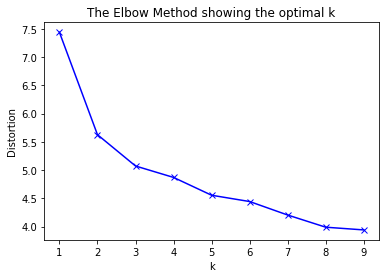

In [69]:
# determine k using elbow method

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Conclusion:
We will conclude the analysis by creating an overview of districts that are similar to Ullevål Stadion according to the K-means cluster analysis and that experience no direct competition from other Chinese restaurants. 

In [70]:
mask_1 = analysis_df['Cluster Labels Restaurant 1'] == 0
solution_df = analysis_df[mask_1]

mask_2 = solution_df['Chinese Restaurant'] == 0 
solution_df = solution_df[mask_2]

solution_df

,Restaurant district,Latitude,Longitude,Venue,Chinese Restaurant,Percent Chinese,Other Asian restaurants,Percent Other Asian,Cluster Labels Restaurant 1,Cluster Labels Restaurant 2
0,Berg,59.949456,10.742028,52,0,0.0,17,32.69,0,3
2,Biermanns gate,59.930445,10.760925,90,0,0.0,29,32.22,0,1
5,Borgen,59.935926,10.696874,50,0,0.0,12,24.00,0,3
48,Sandaker senter,59.938270,10.768504,48,0,0.0,16,33.33,0,3
62,Tåsen,59.948309,10.747627,60,0,0.0,19,31.67,0,3
65,Ullevål stadion,59.949138,10.734360,44,0,0.0,12,27.27,0,3


In [71]:
# Nice presentation

solution_present_df = solution_df.drop(['Latitude', 'Longitude', 'Chinese Restaurant','Cluster Labels Restaurant 1', 'Percent Chinese',
                                           'Cluster Labels Restaurant 2'], axis = 1)

# rename variables 
solution_present_df = solution_present_df.rename(columns={'Venue': 'Venues', 'Other Asian restaurants': 'Asian restaurants',
                                                         'Percent Other Asian': 'Percentage Asian'})

# Turn Restaurant district into index
solution_present_df.set_index('Restaurant district', inplace = True)

solution_present_df

,Venues,Asian restaurants,Percentage Asian
Restaurant district,,,
Berg,52,17,32.69
Biermanns gate,90,29,32.22
Borgen,50,12,24.00
Sandaker senter,48,16,33.33
Tåsen,60,19,31.67
Ullevål stadion,44,12,27.27
